# Homework 02: Multi-Class Classification with Neural Networks

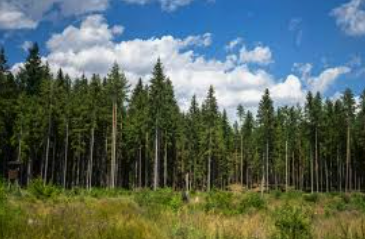

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [1]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

$$k\cdot\sigma$$

In [3]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [9]:
# Your code here
X_train, X_test,y_train, y_test = train_test_split(X_sub,y_sub, stratify=y_sub, random_state=random_seed, test_size=0.2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Mean should be 0 after standardization
# mean_X_train = np.mean(X_train_scaled)
# print(mean_X_train)

# Std dev should be 1 after standardization
# std_dev_X_train = np.std(X_train_scaled)
# print(std_dev_X_train)

### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 299us/step - accuracy: 0.3475 - loss: 18.0251
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.4457 - loss: 3.7793
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.4810 - loss: 2.8683
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.4933 - loss: 2.5730
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.5139 - loss: 2.3298
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.5385 - loss: 2.0698
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.5454 - loss: 1.9258
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.5577 - loss: 1.7804
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.5597 - loss: 1.7438
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - accuracy: 0.5741 - loss: 1.5902
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.5839 - loss: 1.5276
Epoch 12/20
481/481 ━━━━━━━━━

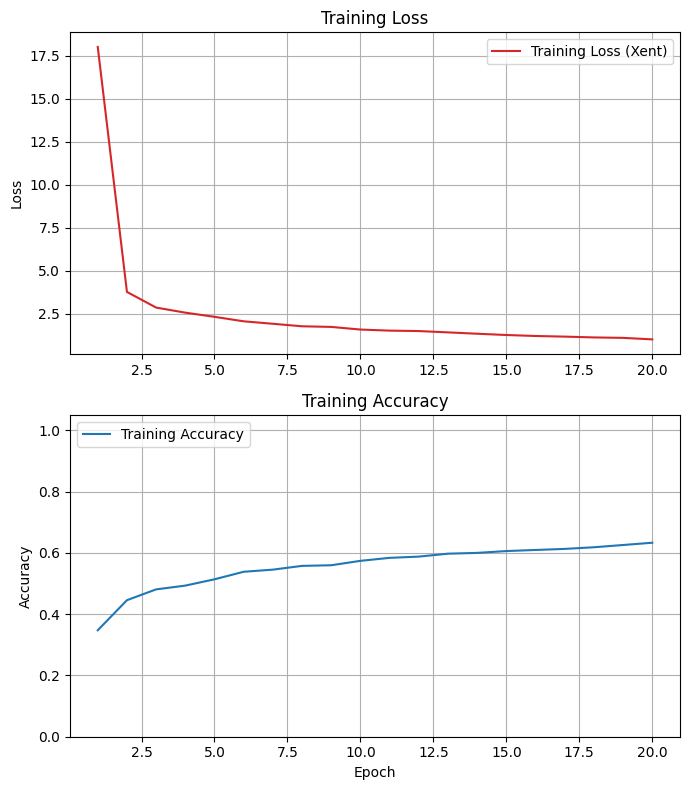

Final Training Loss:     1.0187
Final Training Accuracy: 0.6332


In [15]:
# Your code here
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

forest_model = Sequential([
    Input(shape=(num_features,)),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(num_classes, activation='softmax')
])

opt = Adam(learning_rate=0.001)
forest_model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = opt,
    metrics = ["accuracy"]
)

epochs = 20
batch_size = 32

forest_history = forest_model.fit(X_train,
                                  y_train,
                                  epochs = epochs,
                                  batch_size = batch_size,
                                  verbose=1)

plot_history(forest_history)

In [16]:
# Set a1a to the final training accuracy at epoch 20

a1a = forest_history.history['accuracy'][-1]             # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.6332


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!

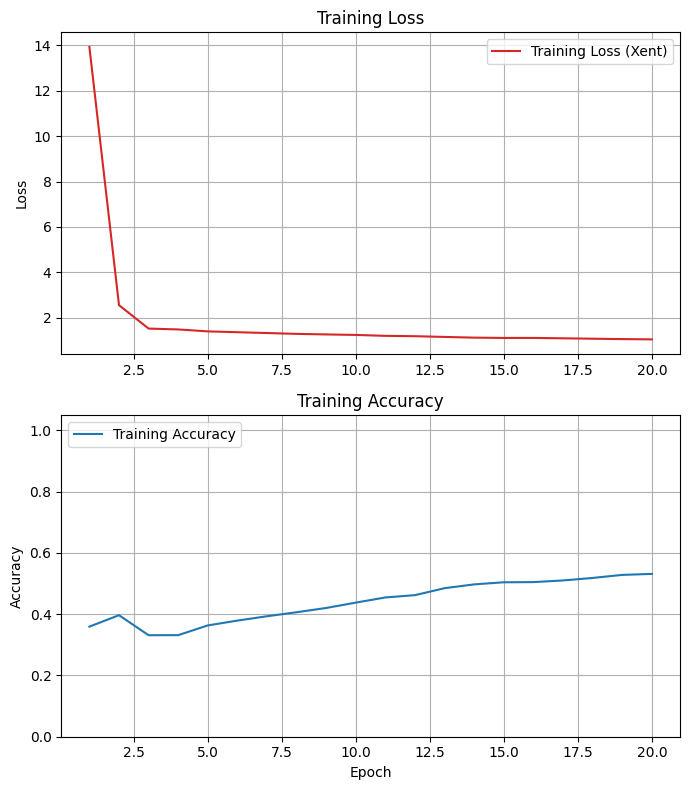

Final Training Loss:     1.0593
Final Training Accuracy: 0.5315


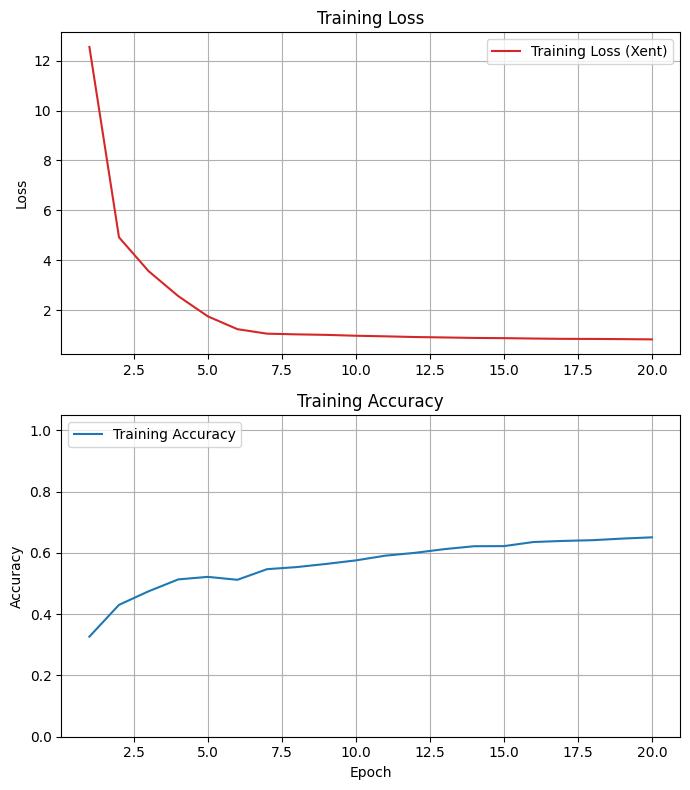

Final Training Loss:     0.8222
Final Training Accuracy: 0.6508


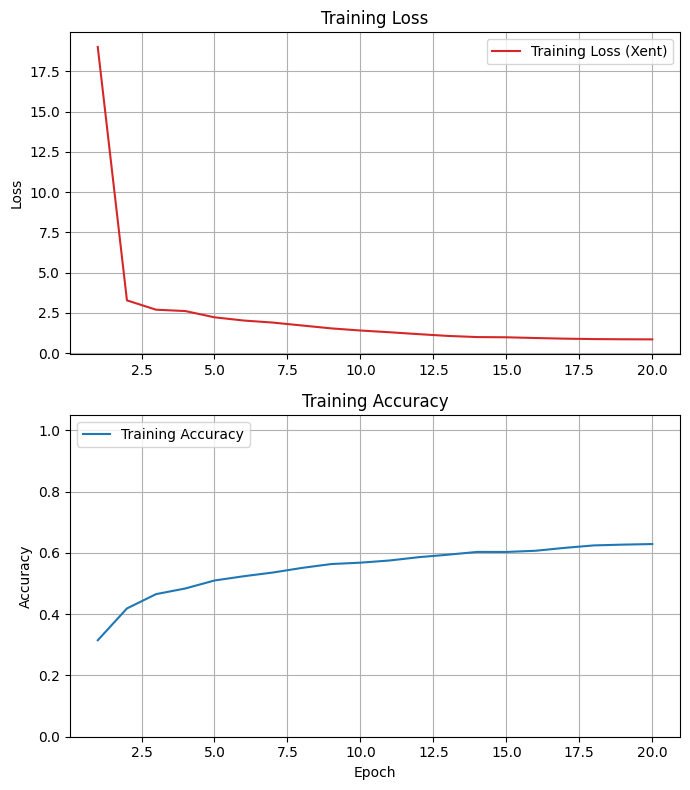

Final Training Loss:     0.8577
Final Training Accuracy: 0.6289


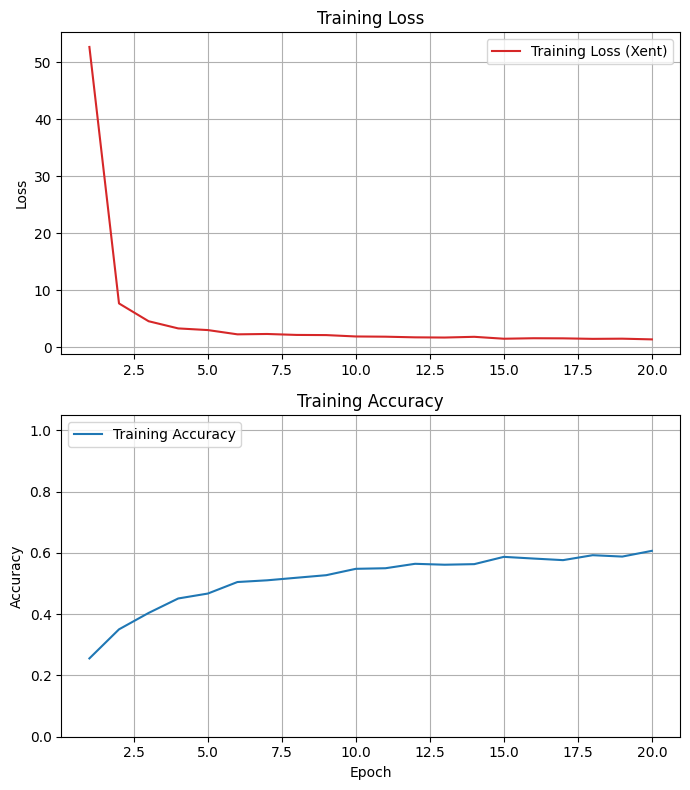

Final Training Loss:     1.3897
Final Training Accuracy: 0.6068
{4: 0.5314958095550537, 8: 0.6508483290672302, 16: 0.6289410591125488, 128: 0.6067737340927124}


In [20]:
# Your code here
batch_size_array = [4,8,16,128]
batch_size_accuracy_dict = {}

num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))
for batch_size_item in batch_size_array:

    forest_model = Sequential([
        Input(shape=(num_features,)),
        Dense(64,activation='relu'),
        Dense(32,activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    opt = Adam(learning_rate=0.001)
    forest_model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = opt,
        metrics = ["accuracy"]
    )

    epochs = 20
    batch_size = 32

    forest_history = forest_model.fit(X_train,
                                    y_train,
                                    epochs = epochs,
                                    batch_size = batch_size_item,
                                    verbose=0)

    plot_history(forest_history)
    batch_size_accuracy_dict[batch_size_item] = forest_history.history['accuracy'][-1]

print(batch_size_accuracy_dict)


In [26]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20
best_batch_size = max(batch_size_accuracy_dict, key=batch_size_accuracy_dict.get)
a2a = best_batch_size             # Replace 0 with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 8


In [28]:
# Set a2b to the best accuracy score found

a2b = batch_size_accuracy_dict[best_batch_size]             # Replace 0.0 with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.6508


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.


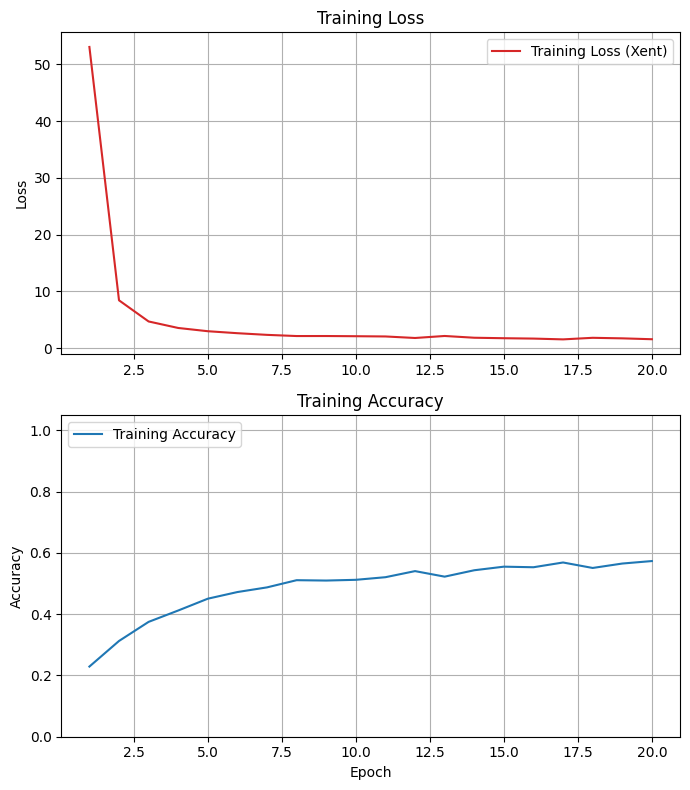

Final Training Loss:     1.5611
Final Training Accuracy: 0.5734


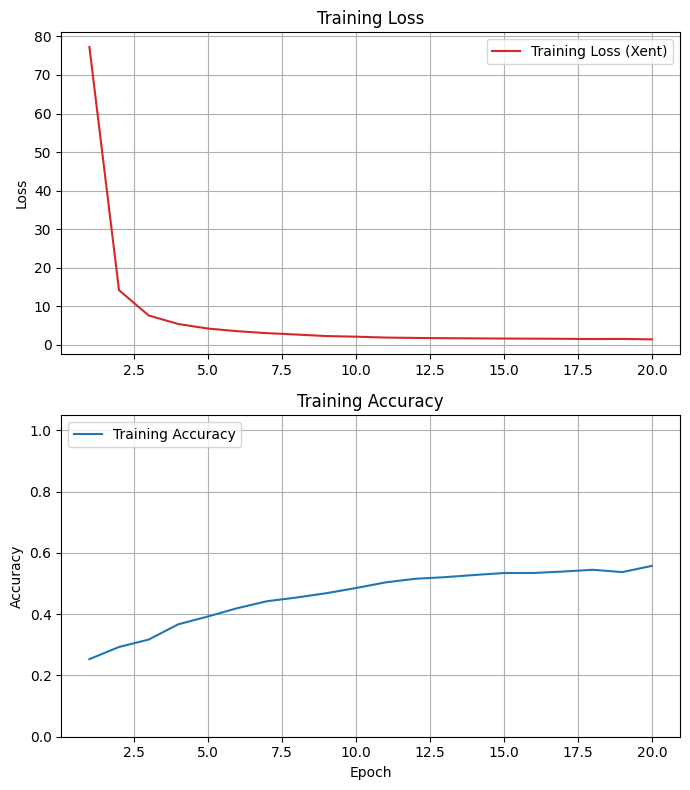

Final Training Loss:     1.4527
Final Training Accuracy: 0.5577


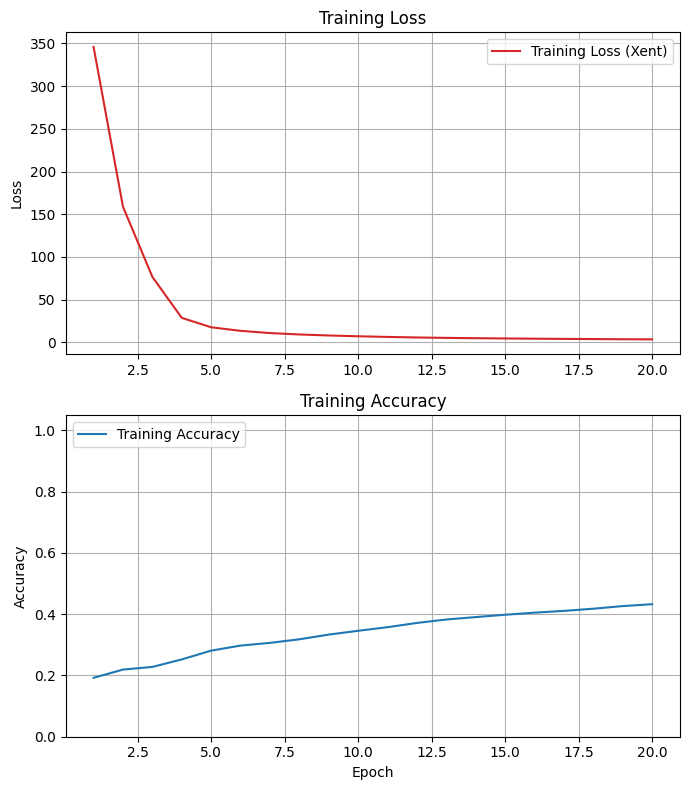

Final Training Loss:     3.4352
Final Training Accuracy: 0.4326


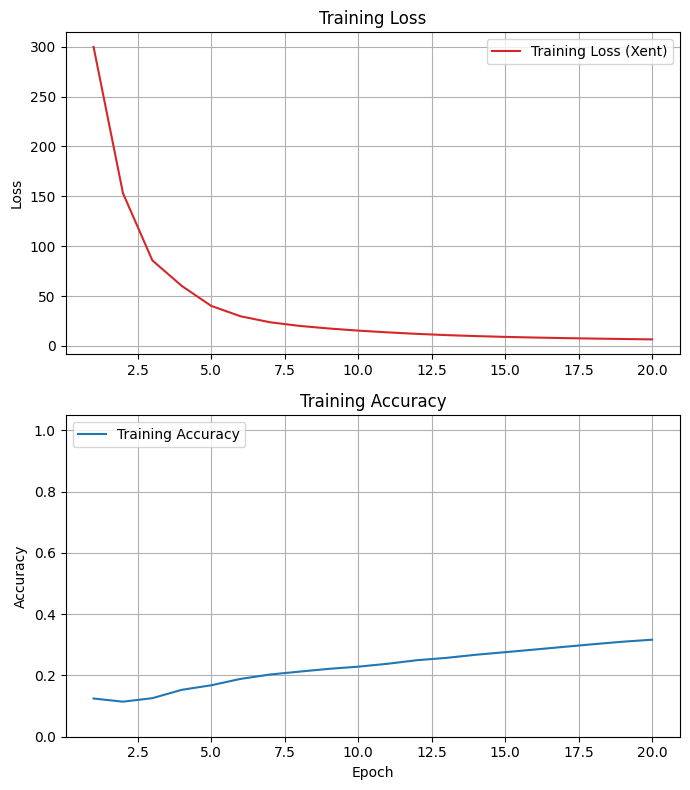

Final Training Loss:     6.6240
Final Training Accuracy: 0.3166


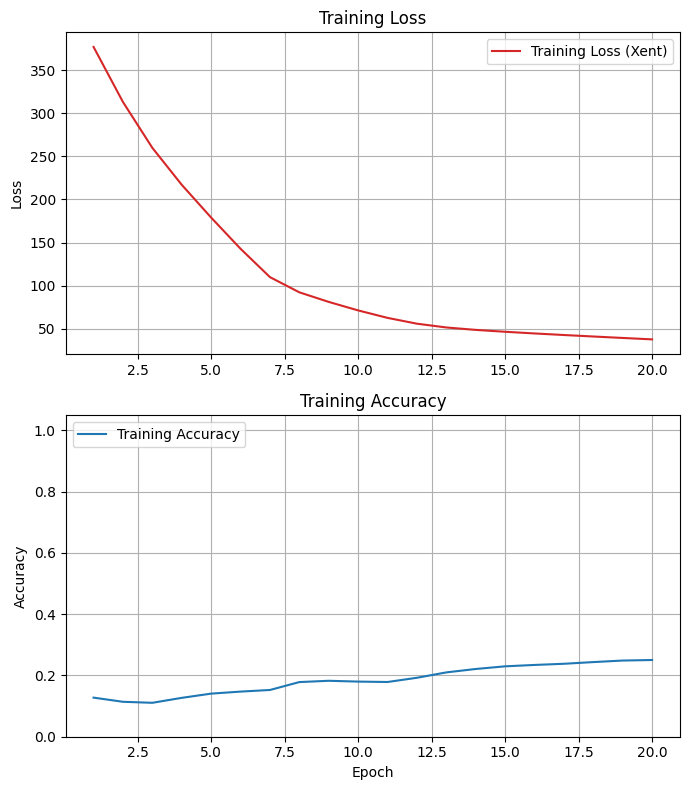

Final Training Loss:     37.8924
Final Training Accuracy: 0.2504
{0.001: 0.5734252333641052, 0.0005: 0.5576935410499573, 0.0001: 0.4325554072856903, 5e-05: 0.3166482448577881, 1e-05: 0.25040629506111145}


In [25]:
# Your code here
learning_rate_array = [1e-3,5e-4,1e-4,5e-5,1e-5]
learning_rate_accuracy_dict = {}

num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

for learning_rate in learning_rate_array:

    forest_model = Sequential([
        Input(shape=(num_features,)),
        Dense(64,activation='relu'),
        Dense(32,activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    opt = Adam(learning_rate=learning_rate)
    forest_model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = opt,
        metrics = ["accuracy"]
    )

    epochs = 20
    batch_size = 32

    forest_history = forest_model.fit(X_train,
                                    y_train,
                                    epochs = epochs,
                                    batch_size = batch_size_item,
                                    verbose=0)

    plot_history(forest_history)
    learning_rate_accuracy_dict[learning_rate] = forest_history.history['accuracy'][-1]

print(learning_rate_accuracy_dict)



In [30]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20
best_learning_rate = max(learning_rate_accuracy_dict, key=learning_rate_accuracy_dict.get)
a3a = best_learning_rate             # Replace 0.0 with your answer

In [31]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [32]:
# Set a3b to the accuracy found by the best learning rate

a3b = learning_rate_accuracy_dict[best_learning_rate]             # Replace 0.0 with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.5734


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 302us/step - accuracy: 0.1391 - loss: 7.7743  
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.1363 - loss: 1.9473
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.1363 - loss: 1.9473
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.1363 - loss: 1.9473
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.1366 - loss: 1.9473
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.1362 - loss: 1.9472
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.1361 - loss: 1.9471
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.1353 - loss: 1.9470
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.1363 - loss: 1.9469
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.1350 - loss: 1.9468
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.1333 - loss: 1.9467
Epoch 12/20
481/481 ━━━━━━━━

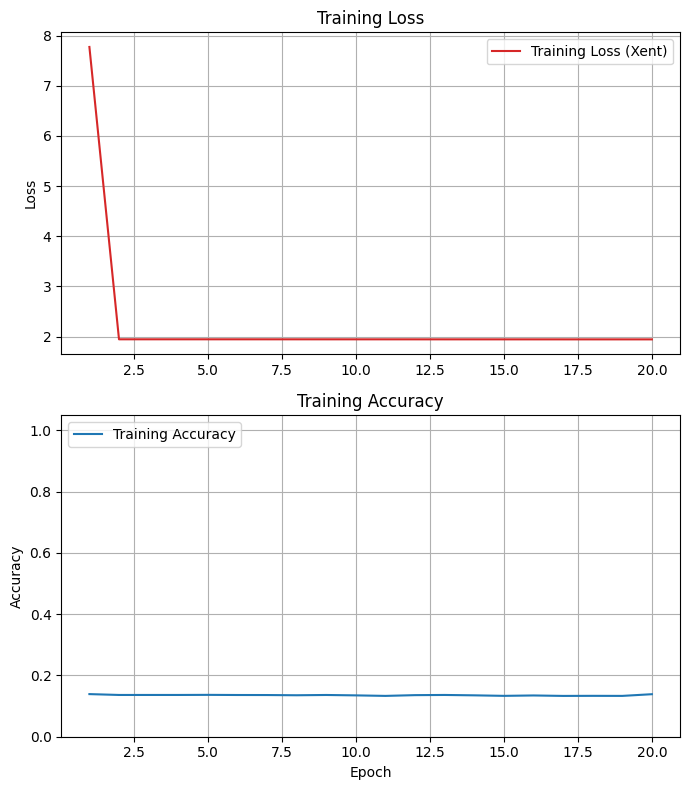

Final Training Loss:     1.9459
Final Training Accuracy: 0.1388
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - accuracy: 0.1679 - loss: 6.7889  
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - accuracy: 0.1427 - loss: 1.9411
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - accuracy: 0.1357 - loss: 1.9449
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.1344 - loss: 1.9469
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.1444 - loss: 1.9428
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.1439 - loss: 1.9370
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.1355 - loss: 1.9466
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.1364 - loss: 1.9465
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.1363 - loss: 1.9465
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - accuracy: 0.1367 - loss: 1.9464
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/ste

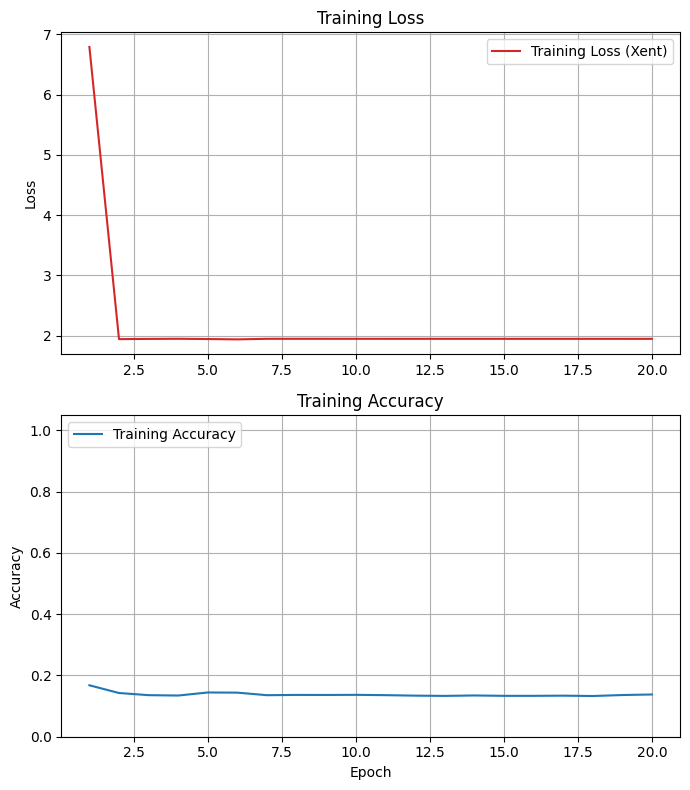

Final Training Loss:     1.9459
Final Training Accuracy: 0.1379
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 316us/step - accuracy: 0.2820 - loss: 18.2394 
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.3656 - loss: 4.9640
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - accuracy: 0.4210 - loss: 3.6275
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.4646 - loss: 2.9427
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.5009 - loss: 2.4465
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.5134 - loss: 2.1996
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.5355 - loss: 1.9896
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.5571 - loss: 1.7739
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.5617 - loss: 1.7380
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.5726 - loss: 1.5830
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/ste

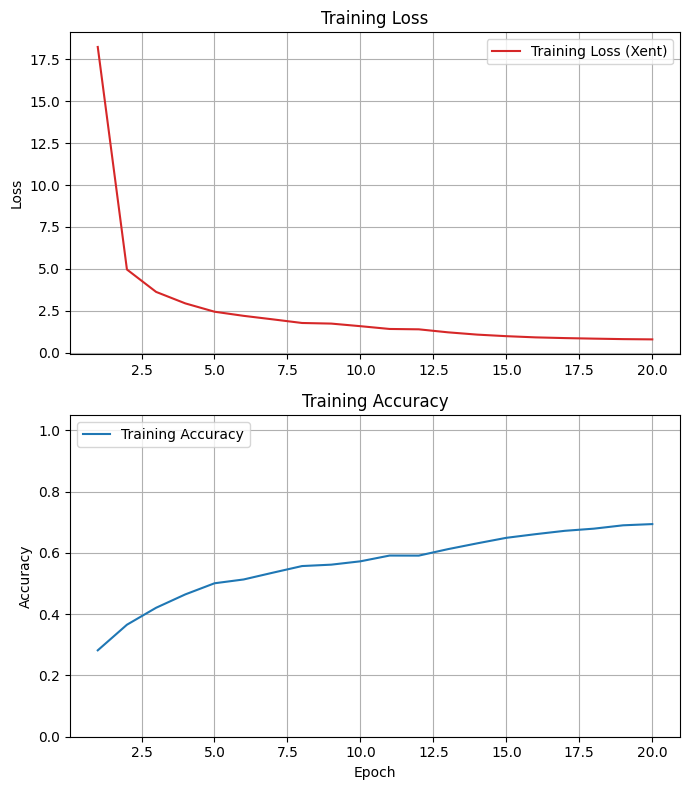

Final Training Loss:     0.7960
Final Training Accuracy: 0.6941
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 298us/step - accuracy: 0.2769 - loss: 19.5369 
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step - accuracy: 0.3525 - loss: 3.9507
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.3992 - loss: 2.6393
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.4424 - loss: 2.0879
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - accuracy: 0.4671 - loss: 1.8083
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.4846 - loss: 1.6416
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.5050 - loss: 1.5085
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - accuracy: 0.5230 - loss: 1.4031
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.5385 - loss: 1.2951
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.5563 - loss: 1.2161
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/ste

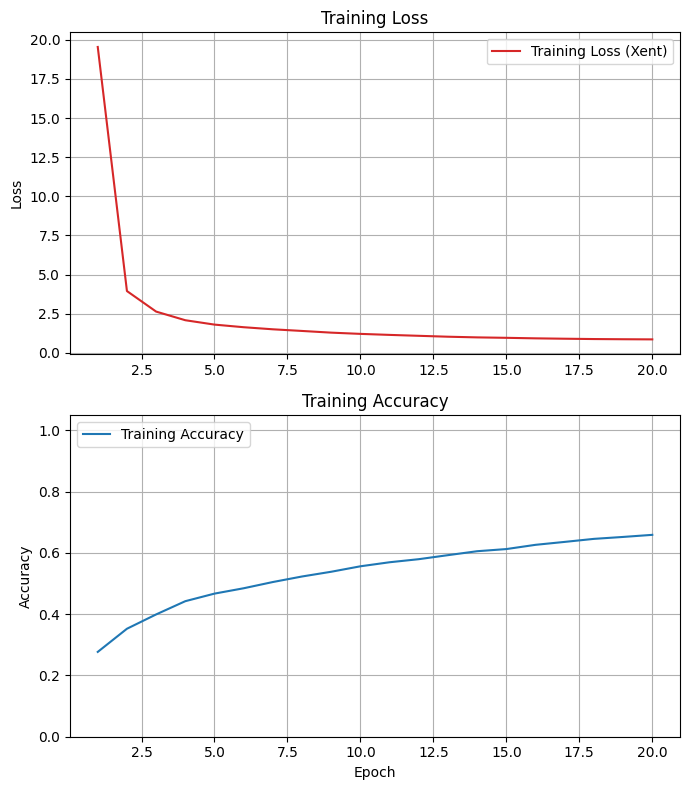

Final Training Loss:     0.8651
Final Training Accuracy: 0.6590
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 304us/step - accuracy: 0.2072 - loss: 137.4138
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.2640 - loss: 16.1722
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - accuracy: 0.3052 - loss: 9.3148 
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.3358 - loss: 6.8489
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.3591 - loss: 5.3768
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.3792 - loss: 4.4259
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.4017 - loss: 3.7853
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.4212 - loss: 3.3280
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.4343 - loss: 3.0059
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - accuracy: 0.4463 - loss: 2.7527
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/s

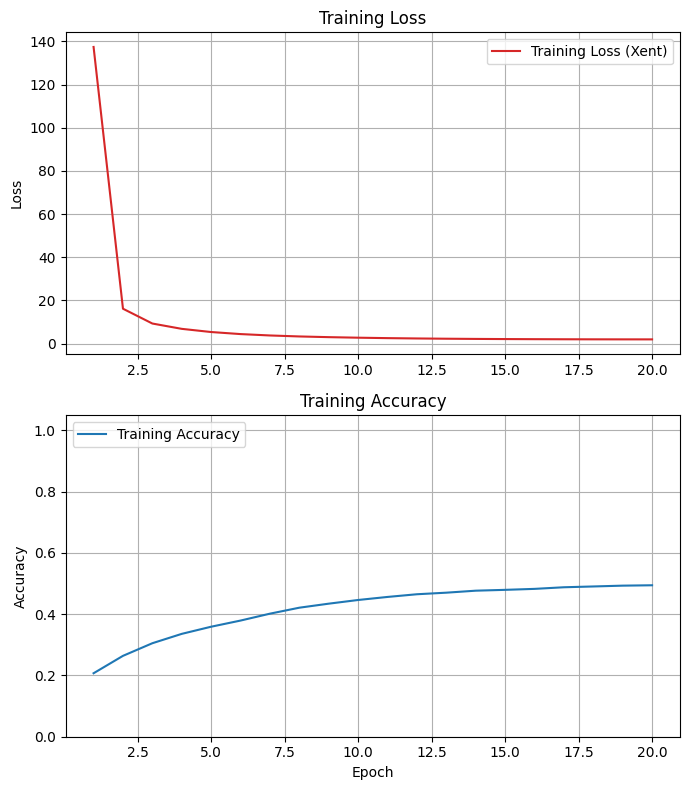

Final Training Loss:     1.9737
Final Training Accuracy: 0.4944
{0.01: 0.1387895792722702, 0.005: 0.13787947595119476, 0.001: 0.6940778493881226, 0.0005: 0.6589741706848145, 0.0001: 0.49437689781188965}


In [37]:
# Your code here
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

epochs = 20
batch_size = 32

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch
initial_learning_rate = [1e-2,5e-3,1e-3,5e-4,1e-4]
learning_rate_cosine_accuracy_dict = {}


for lr in initial_learning_rate:
    cosine_decay = CosineDecay(
            initial_learning_rate = lr,
            decay_steps=total_steps)
    

    forest_model = Sequential([
        Input(shape=(num_features,)),
        Dense(64,activation='relu'),
        Dense(32,activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    opt = Adam(learning_rate=cosine_decay)
    forest_model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = opt,
        metrics = ["accuracy"]
    )

    forest_history = forest_model.fit(X_train,
                                    y_train,
                                    epochs = epochs,
                                    batch_size = batch_size,
                                    verbose=1)
    
    learning_rate_cosine_accuracy_dict[lr] = forest_history.history['accuracy'][-1]
    plot_history(forest_history)

print(learning_rate_cosine_accuracy_dict)


In [38]:
# Set a4a to the initial learning rate which produced the best accuracy
best_cosine_learning_rate = max(learning_rate_cosine_accuracy_dict, key=learning_rate_cosine_accuracy_dict.get)
a4a = best_cosine_learning_rate             # Replace 0.0 with your answer

In [39]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0010


In [40]:
# Set a4b to the best accuracy found

a4b = learning_rate_cosine_accuracy_dict[best_cosine_learning_rate]             # Replace 0.0 with your answer

In [41]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.6941


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 324us/step - accuracy: 0.2789 - loss: 34.5837 
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - accuracy: 0.3799 - loss: 5.8809
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - accuracy: 0.4240 - loss: 4.9481
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.4571 - loss: 4.2613
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - accuracy: 0.4876 - loss: 3.5324
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - accuracy: 0.4996 - loss: 3.2548
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - accuracy: 0.5266 - loss: 2.7922
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.5451 - loss: 2.4147
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - accuracy: 0.5653 - loss: 2.1281
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - accuracy: 0.5697 - loss: 1.9814
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - accuracy: 0.5726 - loss: 1.9150
Epoch 12/20
481/481 ━━━━━━━━

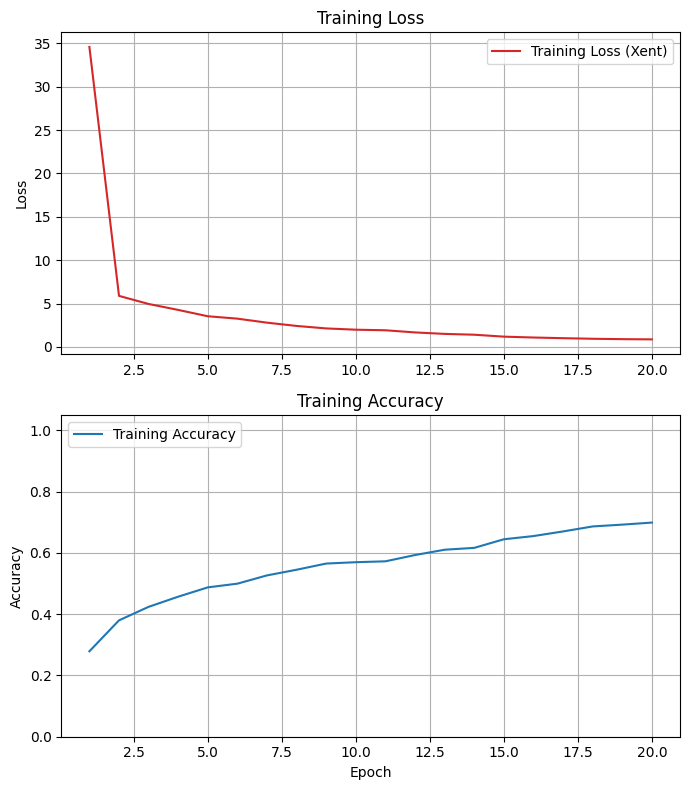

Final Training Loss:     0.8653
Final Training Accuracy: 0.6990


In [49]:
# Your code here -- add as many cells as you need

num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

epochs = 20
batch_size = 32

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch
learning_rate_cosine_accuracy_dict = {}

cosine_decay = CosineDecay(
        initial_learning_rate = 0.001,
        decay_steps=total_steps)


forest_model = Sequential([
    Input(shape=(num_features,)),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(num_classes, activation='softmax')
])

opt = Adam(learning_rate=cosine_decay)
forest_model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = opt,
    metrics = ["accuracy"]
)

forest_history = forest_model.fit(X_train,
                                y_train,
                                epochs = epochs,
                                batch_size = batch_size,
                                verbose=1)

plot_history(forest_history)

test_loss, test_accuracy = forest_model.evaluate(X_test_scaled, y_test, verbose=0)

In [50]:
# Set a5a to the best training accuracy found by your best model

a5a = forest_history.history['accuracy'][-1]             # Replace 0.0 with your answer

In [51]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.6990


In [52]:
# Set a5b to the test accuracy found by your best model

a5b = test_accuracy             # Replace 0.0 with your answer

In [53]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.5153


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


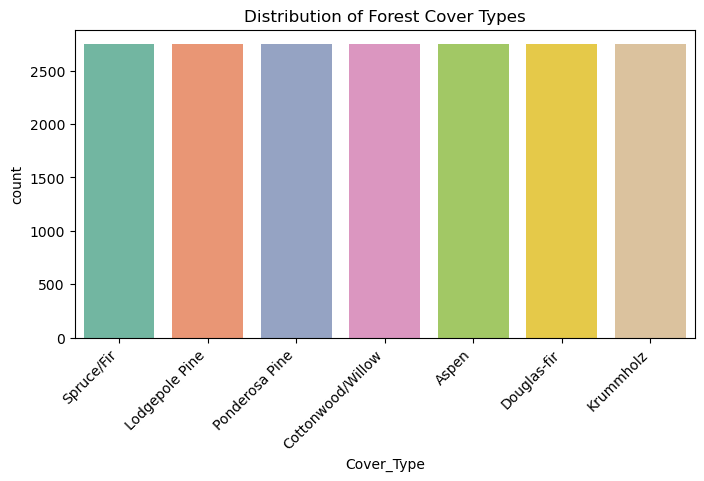

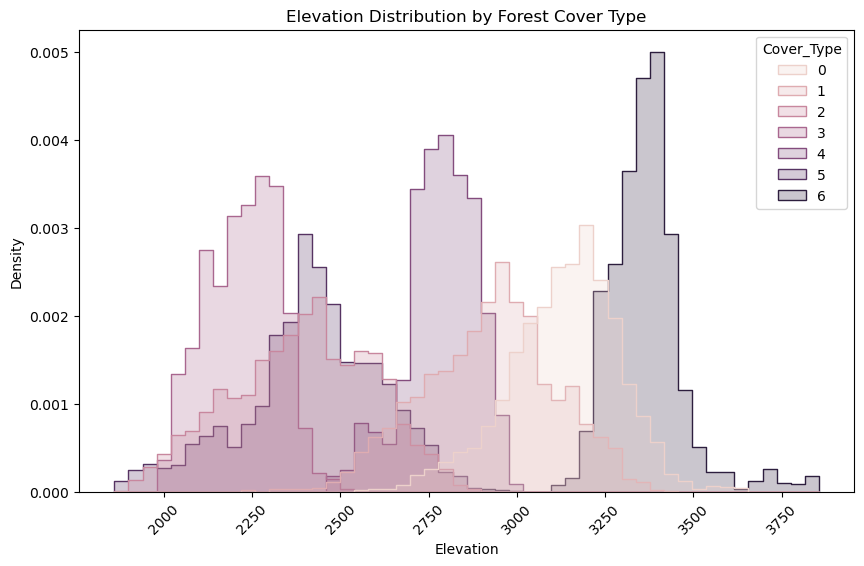

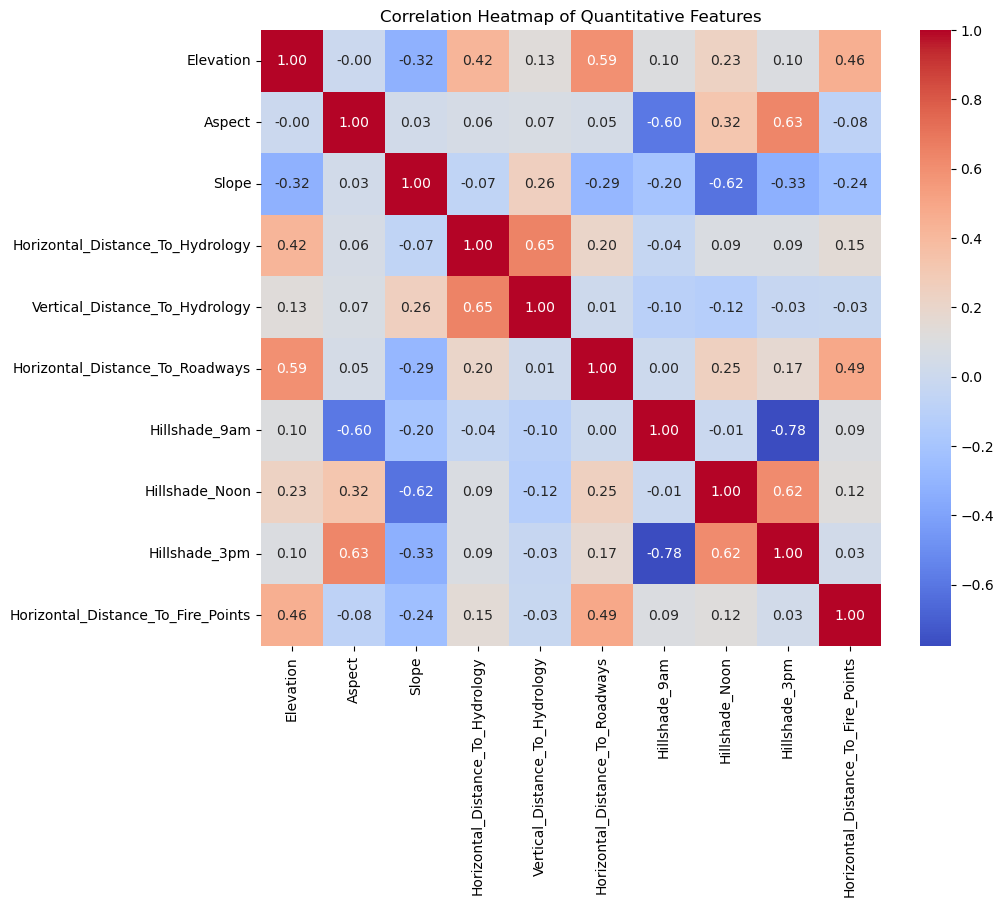

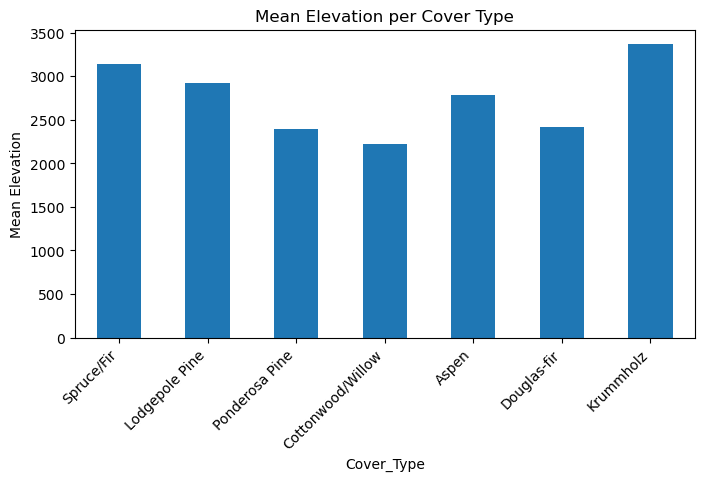

In [28]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
